## 최신 컨브넷 아키텍처 패턴

### 모듈화, 계층화 그리고 재사용
VGG16의 모듈화

![](https://drek4537l1klr.cloudfront.net/chollet2/Figures/09-08.png)

### 잔차 연결
![](https://drek4537l1klr.cloudfront.net/chollet2/Figures/09-09.png)

**필터 개수가 변경되는 잔차 블록**
```
x -3x3-> r -3x3-> h --
           -1x1-> r -- add


x -3x3-> r -3x3-> h -MP-> h --
           -1x1/2-> r -------- add
```

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

# fashion MNIST
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs) # (30,30,32)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x) # (30,30,64)
residual = layers.Conv2D(64, 1)(residual) # (30,30,64)
x = layers.add([x, residual]) # (30,30,64)

**최대 풀링 층을 가진 잔차 블록**

In [2]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs) # (30,30,32)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x) #(30,30,64)
x = layers.MaxPooling2D(2, padding="same")(x) # (15,15,64)
residual = layers.Conv2D(64, 1, strides=2)(residual) # (15,15,64)
x = layers.add([x, residual])
x.shape

TensorShape([None, 15, 15, 64])

위 2개의 블럭을 함수화

In [3]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)

def residual_block(x, filters, pooling=False):
    residual = x # (32,32,3)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x) # (16,16,nF)
        residual = layers.Conv2D(filters, 1, strides=2)(residual) # (16,16,nF)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x

x = residual_block(x, filters=32, pooling=True) # (16,16,32)
x = residual_block(x, filters=64, pooling=True) # (8,8,64)
x = residual_block(x, filters=128, pooling=False)# (8,8,128)

x = layers.GlobalAveragePooling2D()(x) # (128,) : 개별 이미지에 대한 채널별 평균
outputs = layers.Dense(1, activation="sigmoid")(x) # (1,)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 32, 32, 32)   896         ['rescaling[0][0]']              
                                                                                                  
 conv2d_7 (Conv2D)              (None, 32, 32, 32)   9248        ['conv2d_6[0][0]']               
                                                                                              

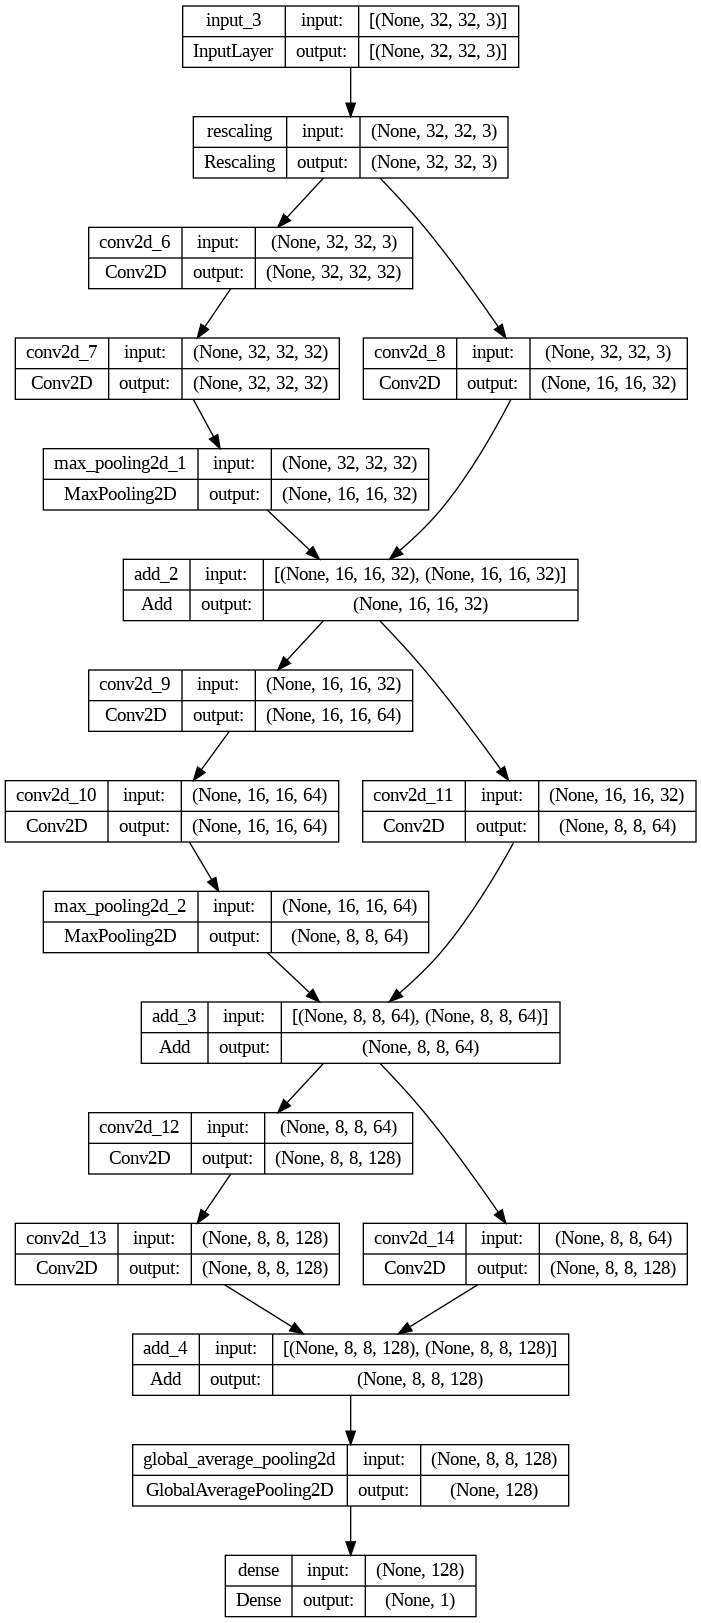

In [5]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

### 배치 정규화
Layer 연산 후, activation 이전에 배치 정규화를 수행함
$$h = \text{ReLU} \left[ \gamma \left( \cfrac {s - \mu_M}{\sigma_M} + \beta \right) \right] $$
- $s = conv(x)$ : 컨볼루션 연산 수행결과
- $\mu_M, \sigma_M$ : s.mean(axis=(0,1,2)), s.std(axis=(0,1,2)). 채널별 평균, 표준편차의 이동평균값
- $\beta, \gamma$ : 학습 파라미터로서 각 채널별 분포를 학습하도록 함
- $4 \times c$ 만큼의 파라미터가 추가되며, 그중 절반만 학습 파라미터

#### 도입 배경
매 배치 마다 입력되는 X의 값이 일정하지 않는 경우가 많다.
- 문제점
    - 학습 막판에 편향된 정답에 의해서 학습 파라미터가 마구 바뀌게 되고
    - 이로 인해 가장 낮은 골짜기로 내려가지 못하고 계곡 주위에서 핑퐁한다.
    - 즉, loss를 낮추기 위해 극단적인 선택을 하도록 유도된다.
- 해결책
    - 전통적으로 통계서는 입력분포가 일정하지 않으면 그 결과의 변동량이 커져서 안정된 모델 예측이 어렵다.
    - 이를 위해 입력 값의 분포를 일정하게 유지해 줄 필요가 있다.
    - 클래스의 수가 많으면 배치 단위에서 편향된-특정 클래스의 샘플이 많은 - 샘플이 모델에 전달되고
    - 이로 인해 불균등 분포의 값이 각 히든에 전달된다.
    - 이를 막기 위해 각 레이어별로 각 채널별로 평균을 구해 각 레이의 분포를 일정하게 유지해준다.
    - 이것을 가능하게 하는 것이 배치 노말라이제이션이다.
- 적용방법
    - 평균과 표준편차를 BN에서 학습하므로
    - BN 이전 단계의 레이어(conv, recurrent, dense, ...)에서
     - use_bias 옵션을 False로 지정하고
     - activation은 사용하지 않는다.
    - 이후 BN 레이어를 적용한 후, Activaion Layer를 통해 activation을 적용한다.


### separable convolution
입출력의 채널이 동일한 컨볼루션 연산의 연산량과 메모리를 줄이기 위해 사용함

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FtsP1w%2FbtqEdwNHplB%2FvUStA61K7wfUhQSd0IYiL0%2Fimg.png)

### depthwise convolution
입출력의 채널이 동일한 컨볼루션 연산의 연산량과 메모리를 줄이기 위해 사용함

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2F0HGnV%2FbtqEfq6N4FD%2FMbAMWX6MMpABhHydEdMb30%2Fimg.png)

### depthwise separable convolution
![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fdm5irH%2FbtqEcopt7cJ%2FEsDEhH61bp9qbAzwW9nBvk%2Fimg.png)

### group convolution
![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fvh9dY%2FbtqEdj150UH%2F6A04ddKlEZyOSJgufpluP1%2Fimg.png)

### Xception 유사 모델에 모두 적용하기

캐글에서 dogs-vs-cats 데이터셋을 다운로드하려면 캐글에 가입해야 한 후 생성한 API 키를 사용해야 합니다. 이런 과정이 번거롭다면 다음 명령으로 구글 드라이브에서 직접 다운로드할 수 있습니다.

```python
import gdown
gdown.download(id='18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd', output='dogs-vs-cats.zip')
```

그다음 아래 2개의 코드 셀을 건너 뛰고 바로 `unzip` 명령을 실행하세요.

In [6]:
import gdown
gdown.download(id='18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd', output='dogs-vs-cats.zip')
# gdown.download(id='1owQOG6Z-IX-dq9lViwliZnolkrltmYM2', output='dogs-vs-cats.zip')
# https://drive.google.com/file/d/1owQOG6Z-IX-dq9lViwliZnolkrltmYM2/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd
To: /content/dogs-vs-cats.zip
100%|██████████| 852M/852M [00:13<00:00, 63.5MB/s]


'dogs-vs-cats.zip'

In [ ]:
# # kaggle.json 파일을 업로드하세요.
# from google.colab import files
# files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"haesunpark","key":"08f234c75bf1f9cff6991a8a6d5d49ac"}'}

In [ ]:
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle competitions download -c dogs-vs-cats

In [8]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A


In [9]:
import os, shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [10]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [11]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x) # (176,176,32)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x) # (88,88,32)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual]) # (88,88,32) => (44,44,64) => (22,22,128) => (11,11,256) => (6,6,512)

x = layers.GlobalAveragePooling2D()(x) #(512,)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_4[0][0]']                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 180, 180, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d_15 (Conv2D)             (None, 176, 176, 32  2400        ['rescaling_1[0][0]']      

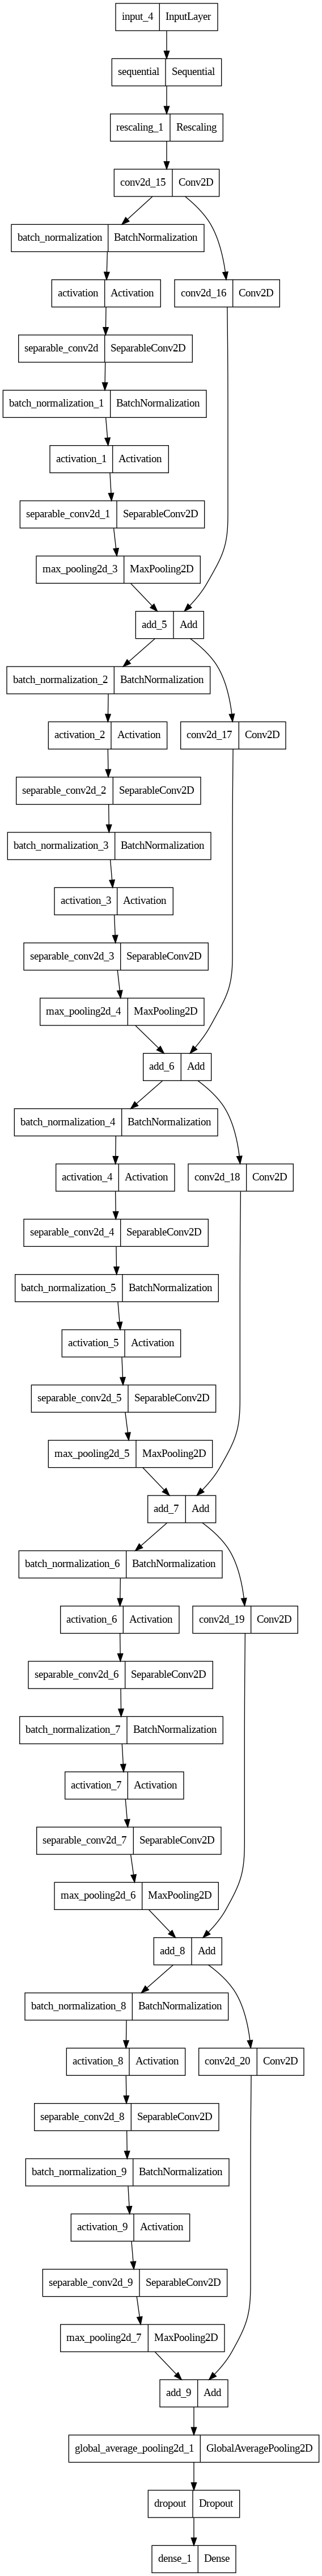

In [12]:
plot_model(model)

In [14]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset)

Epoch 1/100
63/63 [==============================] - 32s 188ms/step - loss: 0.7009 - accuracy: 0.5545 - val_loss: 0.6928 - val_accuracy: 0.4990
Epoch 2/100
63/63 [==============================] - 9s 141ms/step - loss: 0.6541 - accuracy: 0.6110 - val_loss: 0.6925 - val_accuracy: 0.5230
Epoch 3/100
63/63 [==============================] - 10s 146ms/step - loss: 0.6519 - accuracy: 0.6155 - val_loss: 0.7082 - val_accuracy: 0.5000
Epoch 4/100
63/63 [==============================] - 9s 144ms/step - loss: 0.6318 - accuracy: 0.6390 - val_loss: 0.6947 - val_accuracy: 0.4990
Epoch 5/100
63/63 [==============================] - 10s 157ms/step - loss: 0.6243 - accuracy: 0.6590 - val_loss: 0.7685 - val_accuracy: 0.5000
Epoch 6/100
63/63 [==============================] - 9s 140ms/step - loss: 0.6138 - accuracy: 0.6650 - val_loss: 0.7465 - val_accuracy: 0.5000
Epoch 7/100
63/63 [==============================] - 9s 143ms/step - loss: 0.6024 - accuracy: 0.6845 - val_loss: 0.7403 - val_accuracy: 0.5

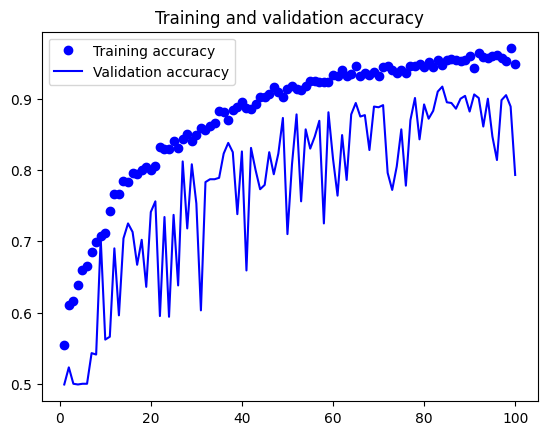

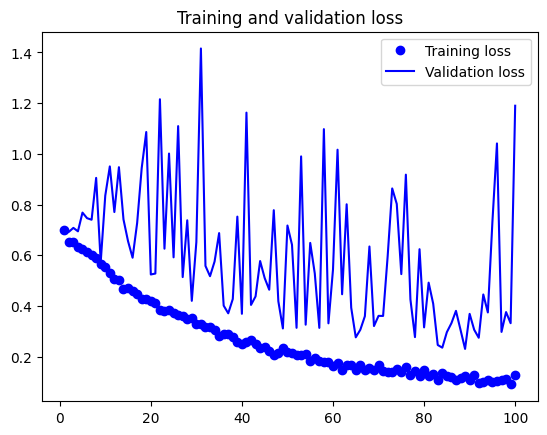

In [15]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()